# Let's give Wheatlo a try

In [1]:
import pandas as pd

import os

import matplotlib.pyplot as plt

import cv2

from albumentations import Compose, PadIfNeeded, LongestMaxSize

import darknet as dn
import util as util
import util2 as util2

from torch.utils.data import Dataset, DataLoader
import torch

import numpy as np

In [2]:
np.set_printoptions(precision=4, suppress = True, edgeitems = 8)

In [3]:
inp_dim = 416
stride = 32
num_anchors = 6

confidence = 0.5
nms_thesh = 0.3

batch_size = 8
width = 1024
height = 1024

#### The images in the test set were not used in the training.

In [4]:
img_dir = "../wheat/test/"

## 1. Create a PyTorch Dataset of the test images

In [5]:
data = pd.DataFrame({"image_id":os.listdir(img_dir)})

In [6]:
img_transform = Compose([LongestMaxSize(inp_dim), PadIfNeeded(inp_dim, inp_dim, cv2.BORDER_CONSTANT)])

In [7]:
class ImgDataset(Dataset):
    
    def __init__(self, img_dir, data_table, img_transform):
        
        self.imgdir = img_dir
        self.table = data_table
      
        self.imgtransform = img_transform

    def __len__(self):
        return len(self.table)

    def __getitem__(self, idx):     
        
        mat = cv2.imread(self.imgdir+self.table.iloc[idx]['image_id'])    
        
        augmented = self.imgtransform(image = mat)
        mat = augmented['image']  
        
        mat = mat[:,:,::-1].transpose((2,0,1)).copy()
        img = torch.from_numpy(mat).div(255.0)
       
        return (idx, img)

In [8]:
imgds = ImgDataset(img_dir, data, img_transform)

In [9]:
imgloader = DataLoader(imgds, batch_size= batch_size, shuffle=False)

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## 2. Build Wheatlo

In [11]:
cfgfile = "../cfg/darknet_feature_extractor.cfg"

model = dn.Darknet(cfgfile, inp_dim)
cfgfile = "../cfg/yolov3_detector.cfg"
model.add_detector_layers(cfgfile)
model.load_state_dict(torch.load("wheatlo_detector_5anchors_stage2.pth"))

Total number of lines in file: 555
Total number of lines in file: 70


<All keys matched successfully>

## 3. Visualizer the output

In [12]:
m=model.eval()
m=model.to(device)

/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


Total number of bounding box found: 154
Total number of bounding box found: 44


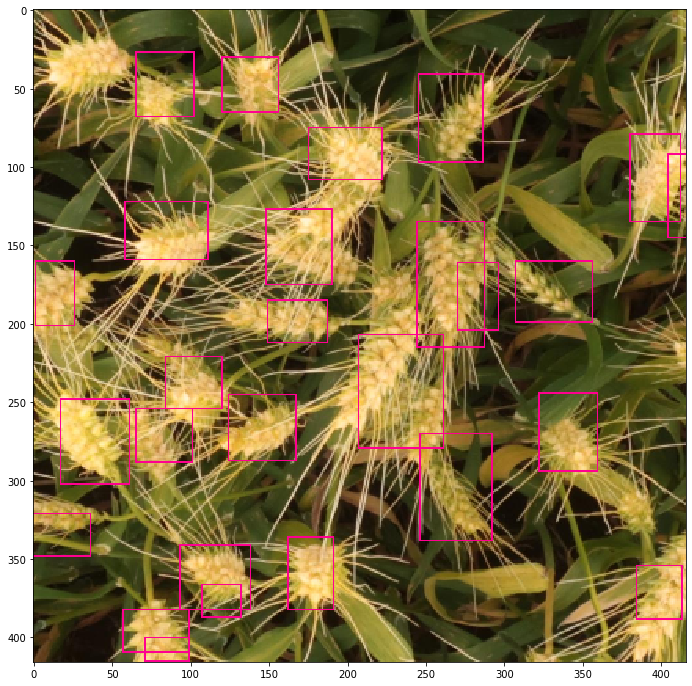

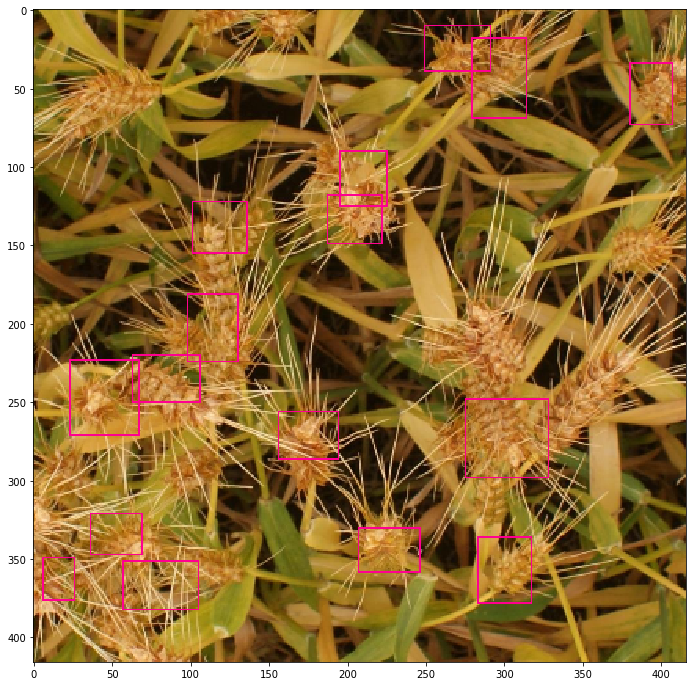

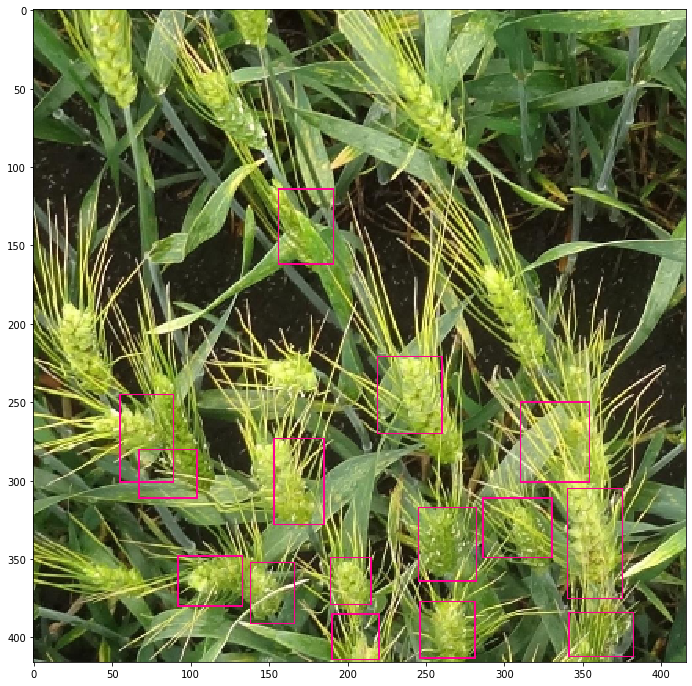

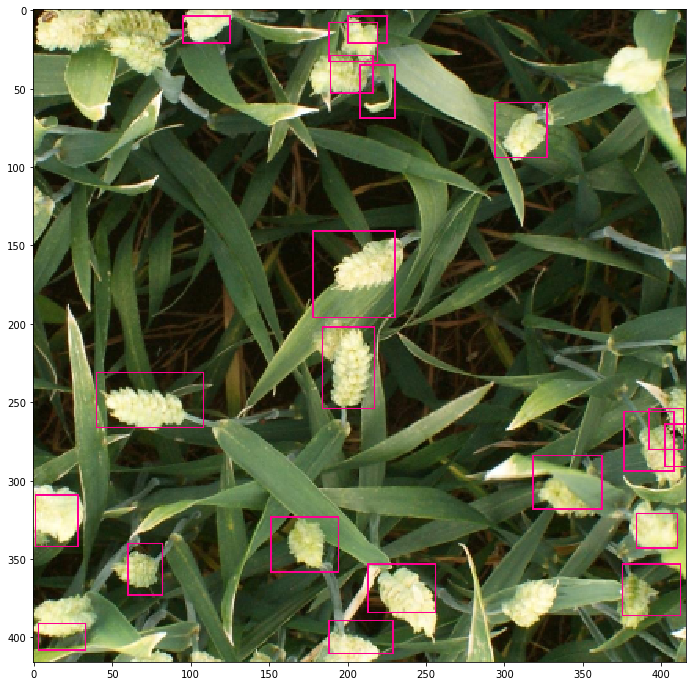

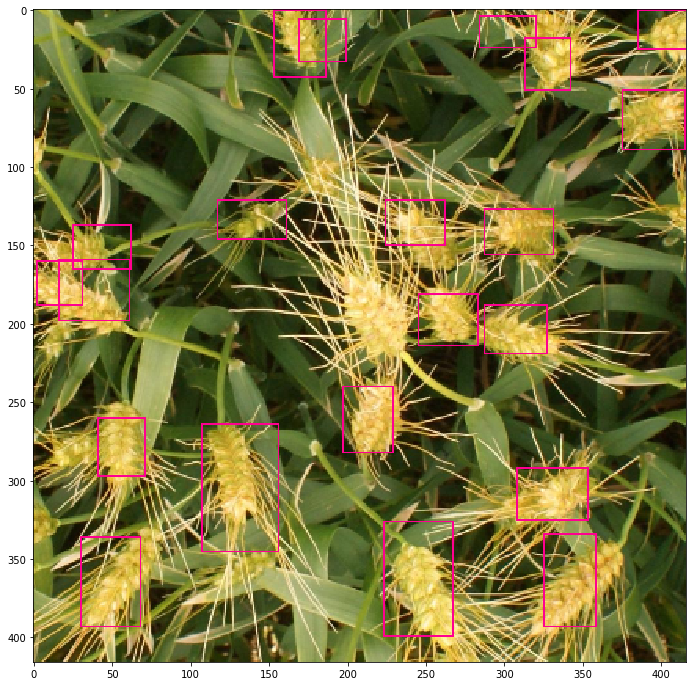

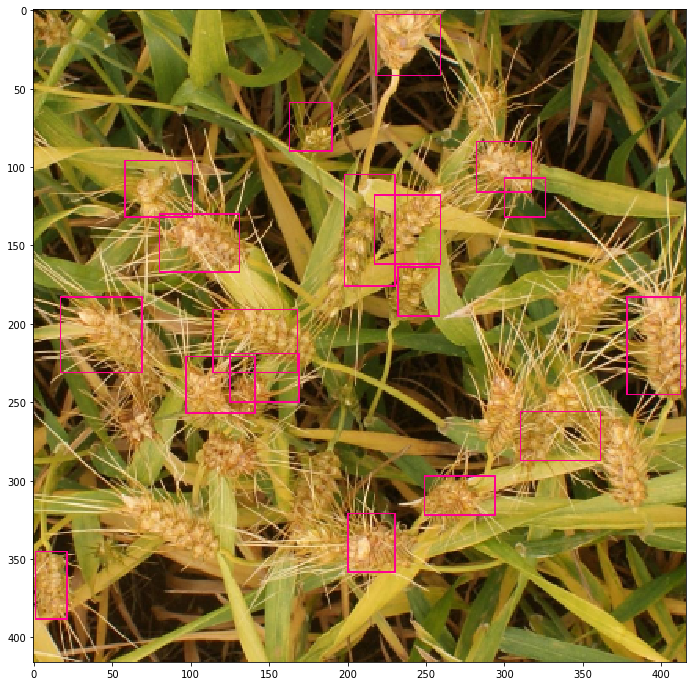

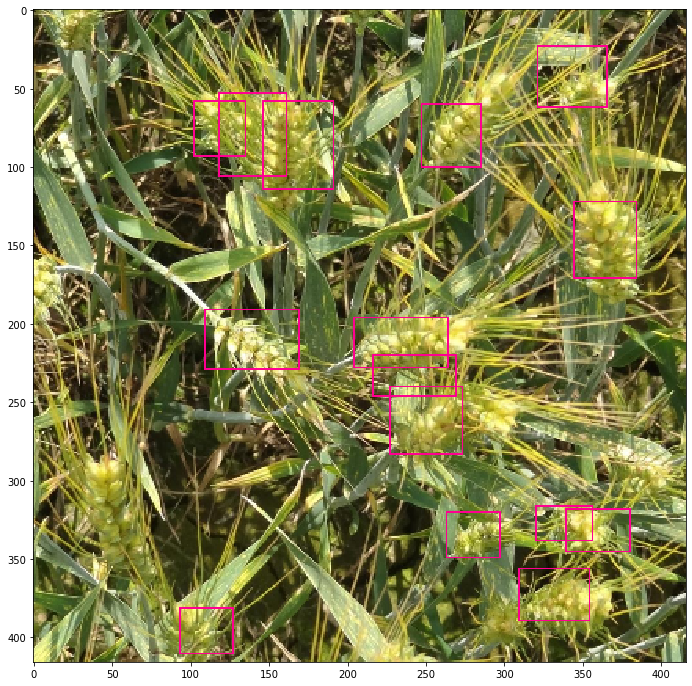

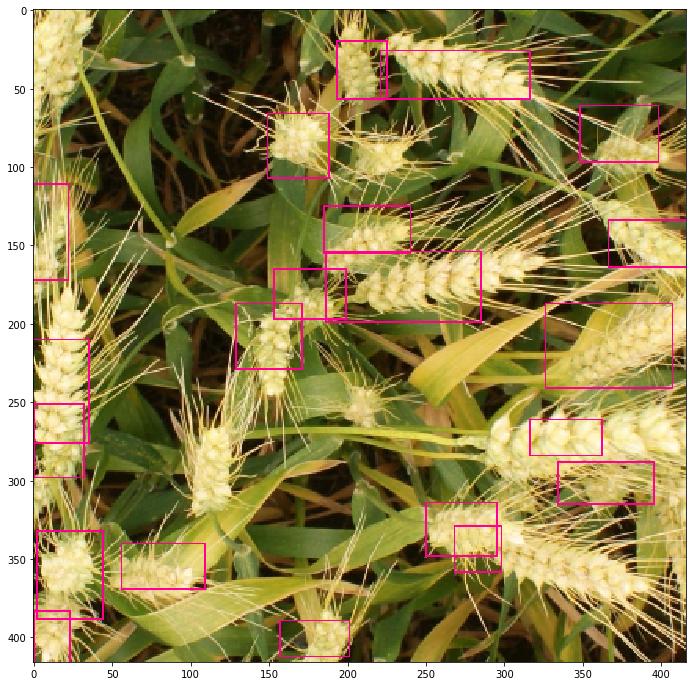

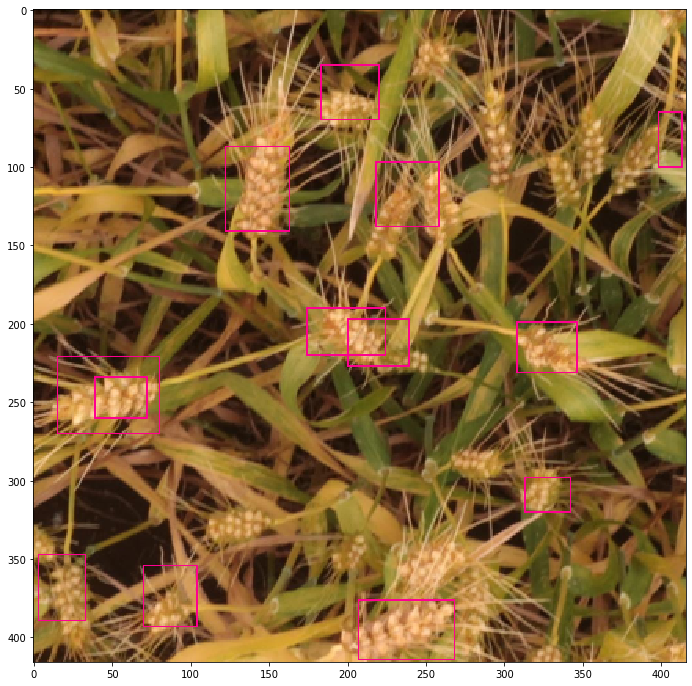

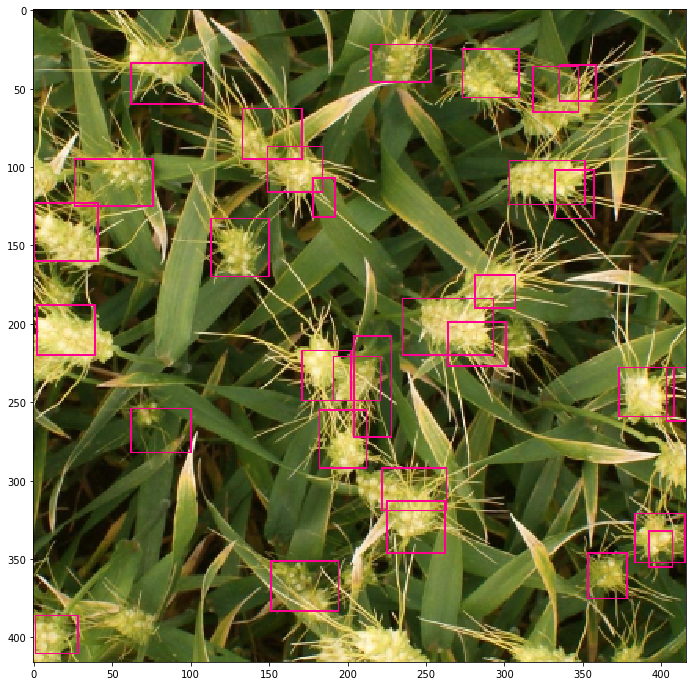

In [13]:
output = {}
for i, (idx,img) in enumerate(imgloader):

    img = img.to(device)

    with torch.set_grad_enabled(False):
        prediction = model(img)

        prediction = util.write_results(prediction, confidence, nms_conf = nms_thesh)

    if type(prediction) == int:
        print("no prediction found")
        continue 

    print(f"Total number of bounding box found: {prediction.shape[0]}")    
    for j in range(prediction.shape[0]):

        batch_id = int(prediction[j,0])

        #create a dictionary, the key is the row index in the data table (each row is one image), 
        #the value is rows of predctions for that image
        table_index = idx[batch_id].item()

        if (table_index in output):
            output[table_index] = torch.cat((output[table_index], prediction[j,1:].unsqueeze(0)),0)
        else:
            output[table_index] = prediction[j,1:].unsqueeze(0)
    

util2.visualize_detector_output(output, data, img_dir, img_transform) 